In [4]:

#Step 1: Read image and define pixel size (if needed to convert results into microns, not pixels)
#Step 2: Denoising, if required and threshold image to separate grains from boundaries.
#Step 3: Clean up image, if needed (erode, etc.) and create a mask for grains
#Step 4: Label grains in the masked image
#Step 5: Measure the properties of each grain (object)
#Step 6: Output results into a csv file


In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import measure, color, io

In [6]:
img=cv2.imread("images/grain.jpg",0)

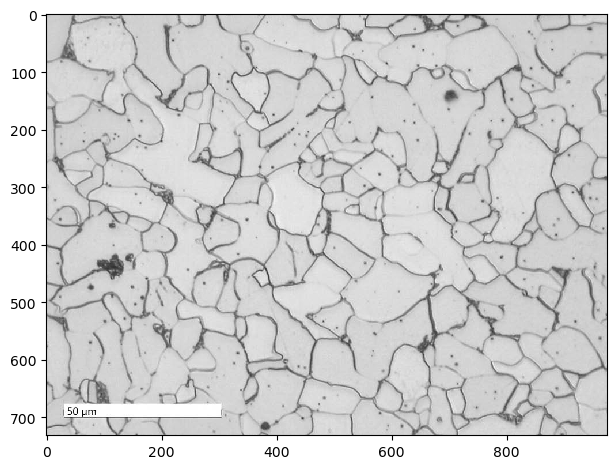

In [7]:
io.imshow(img)

In [8]:
pixels_to_um = 0.05 # (1 px = 50 nm)

(array([3.00000e+01, 1.50000e+01, 0.00000e+00, 6.00000e+00, 0.00000e+00,
        4.00000e+00, 4.00000e+00, 4.00000e+00, 1.00000e+00, 5.00000e+00,
        4.00000e+00, 1.00000e+00, 5.00000e+00, 7.00000e+00, 3.00000e+00,
        2.00000e+00, 4.00000e+00, 6.00000e+00, 5.00000e+00, 8.00000e+00,
        2.00000e+01, 2.90000e+01, 2.70000e+01, 6.60000e+01, 7.70000e+01,
        1.92000e+02, 1.73000e+02, 2.23000e+02, 1.49000e+02, 3.51000e+02,
        4.32000e+02, 4.07000e+02, 7.59000e+02, 5.66000e+02, 1.05800e+03,
        7.44000e+02, 1.32400e+03, 9.97000e+02, 1.52800e+03, 1.20600e+03,
        2.02500e+03, 2.10600e+03, 1.55000e+03, 2.29500e+03, 1.63800e+03,
        2.59800e+03, 1.77900e+03, 2.80400e+03, 1.95000e+03, 2.95400e+03,
        3.18000e+03, 1.98300e+03, 3.06400e+03, 2.13900e+03, 3.18900e+03,
        2.13000e+03, 3.39100e+03, 2.28700e+03, 3.43400e+03, 2.42100e+03,
        3.50100e+03, 3.80400e+03, 2.53800e+03, 3.92100e+03, 2.61000e+03,
        4.17000e+03, 2.88100e+03, 4.50900e+03, 3.13

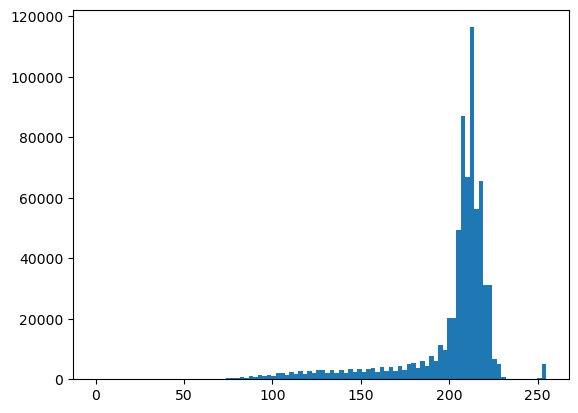

In [10]:
plt.hist(img.flat,bins=100,range=(0,255))

In [11]:
ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

172.0


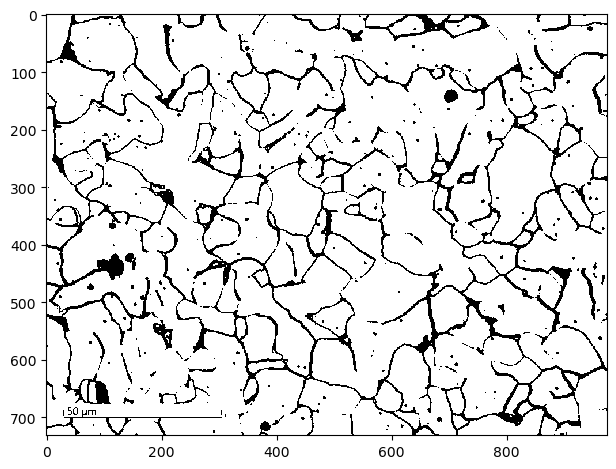

In [13]:
io.imshow(thresh)
print(ret)

In [14]:
kernel = np.ones((3,3),np.uint8) 
eroded = cv2.erode(thresh,kernel,iterations = 1)
dilated = cv2.dilate(eroded,kernel,iterations = 1)

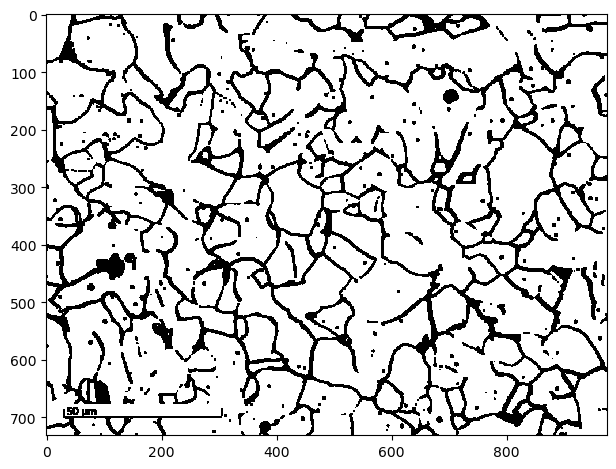

In [16]:
io.imshow(eroded)


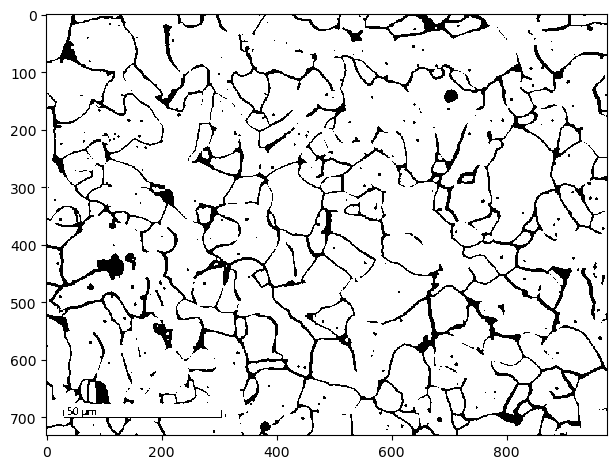

In [17]:
io.imshow(dilated)

In [41]:
mask1 = thresh == 255
mask2 = eroded == 255
mask3 = dilated == 255

In [42]:
print(mask1)
print(mask2)
print(mask3)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


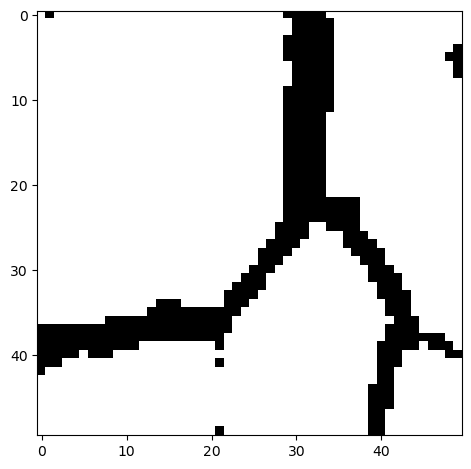

In [44]:
io.imshow(mask1[100:150, 250:300])

In [46]:
s = [[1,1,1],[1,1,1],[1,1,1]]
labeled_mask1, num_labels1 = ndimage.label(mask1, structure=s)
labeled_mask2, num_labels2 = ndimage.label(mask2, structure=s)
labeled_mask3, num_labels3 = ndimage.label(mask3, structure=s)

In [47]:
img2 = color.label2rgb(labeled_mask1, bg_label=0)
img3 = color.label2rgb(labeled_mask2, bg_label=0)
img4 = color.label2rgb(labeled_mask3, bg_label=0)

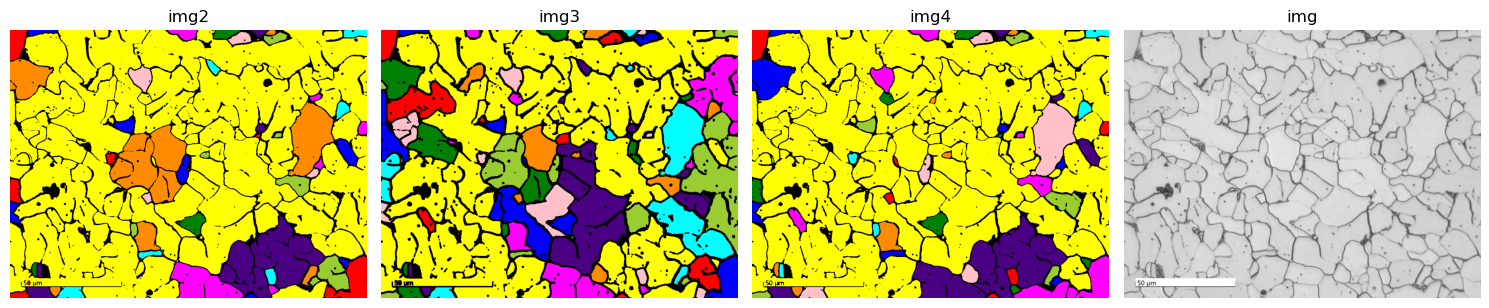

In [55]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.title("img2")
plt.imshow(img2, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("img3")
plt.imshow(img3, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("img4")
plt.imshow(img4, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("img")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [56]:
clusters = measure.regionprops(labeled_mask2, img)

In [57]:
propList = ['Area',
            'equivalent_diameter',
            'orientation', 
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter',
            'MinIntensity',
            'MeanIntensity',
            'MaxIntensity']    
    

output_file = open('image_measurements.csv', 'w')
output_file.write(',' + ",".join(propList) + '\n') #join strings in array by commas, leave first cell blank
#First cell blank to leave room for header (column names)

for cluster_props in clusters:
    #output cluster properties to the excel file
    output_file.write(str(cluster_props['Label']))
    for i,prop in enumerate(propList):
        if(prop == 'Area'): 
            to_print = cluster_props[prop]*pixels_to_um**2   #Convert pixel square to um square
        elif(prop == 'orientation'): 
            to_print = cluster_props[prop]*57.2958  #Convert to degrees from radians
        elif(prop.find('Intensity') < 0):          # Any prop without Intensity in its name
            to_print = cluster_props[prop]*pixels_to_um
        else: 
            to_print = cluster_props[prop]     #Reamining props, basically the ones with Intensity in its name
        output_file.write(',' + str(to_print))
    output_file.write('\n')
output_file.close()   #Closes the file, otherwise it would be read only. 

In [58]:
import pandas as pd

In [59]:
df=pd.read_csv('image_measurements.csv')
df.head(10)

,Unnamed: 0,Area,equivalent_diameter,orientation,MajorAxisLength,MinorAxisLength,Perimeter,MinIntensity,MeanIntensity,MaxIntensity
0,1,6.9550,2.975799,-11.220679,4.535220,2.097811,11.721320,189.0,203.896837,214.0
1,2,1.4450,1.356404,-85.558182,4.317137,0.597703,8.484924,178.0,206.586505,217.0
2,3,721.6075,30.311371,-52.493626,55.526700,33.982390,1083.249202,173.0,213.182073,255.0
3,4,1.4750,1.370412,86.171800,1.812770,1.076703,4.921016,196.0,211.903390,222.0
4,5,3.1225,1.993913,81.730469,3.548411,1.343026,9.164518,193.0,211.044836,238.0
5,6,0.0025,0.056419,45.000016,0.000000,0.000000,0.000000,232.0,232.000000,232.0
6,7,2.8075,1.890667,-80.643386,3.315867,1.152268,8.209188,190.0,208.186999,235.0
7,8,1.0200,1.139607,89.652919,1.737181,0.903823,4.879899,189.0,202.803922,213.0
8,9,0.5075,0.803846,-76.412016,1.128614,0.593323,2.871016,179.0,203.763547,218.0
9,10,2.4800,1.776973,-86.539099,3.647071,0.974945,8.450305,186.0,208.574597,222.0
